## Integral by Interpolation ##

We want to use a NN to calculate the integral $I$ of a polynomial function in the form of: 

$$I = \int_{0}^{B} (αx^2 + βx + γ)\, dx \, \Longrightarrow$$ 
$$ = \frac{α}{3}B^3 + \frac{β}{2}B^2 + γB $$ 

In [1]:
# Command
%load_ext autoreload
%autoreload 2

# Modules 
import sys
sys.path.insert(0, '/home/lsantiago/workspace/ic/project/')
import os
import numpy as np
import torch
from src import nn_architecture as NN
from src import model_training as mt
from src import generic as gc
from src.generate_poly_dataset import PolyDataset, ToTensor
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Paths
working_path = sys.path[0]
path_to_data = os.path.join(working_path, 'data')
path_to_models = os.path.join(working_path, 'models')
path_to_images = os.path.join(working_path, 'images')
data = os.path.join(path_to_data, 'poly_data.npy')

# Parameters
torch.set_default_dtype(torch.float64)

Model and training parameters

In [2]:
batch_size = 64
lr = 0.01
epochs = 100
n_sample = 100000
full_data = True

Get and split dataset

In [3]:
poly_data = np.load(data) # Load polynomials numpy array
poly_data = poly_data.astype(np.float64)
if not full_data:
    poly_data = poly_data[:n_sample]
poly_data = poly_data[:, :-1], poly_data[:, -1]
data_size = len(poly_data[0]) if not full_data else None
transformed_dataset = PolyDataset(poly_data, transform=ToTensor())
X, y = transformed_dataset.data
print(X.shape, y.shape)

training_data, test_data = gc.split_dataset(transformed_dataset, seed=42)

(1000000, 4) (1000000,)


Create data loaders

In [4]:
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size,
                             shuffle=True)

for X, y in test_dataloader:
    print(f'Shape of X [α, β, γ, B]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [α, β, γ, B]: torch.Size([64, 4])
Shape of y: torch.Size([64]) torch.float64


Define NN architecture

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = NN.NeuralNetwork().to(device)
nodes_config = NN.nodes_config
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=40, bias=True)
    (11): ReLU()
    (12): Linear(in_features=40, out_features=1, bias=True)
  )
)


In [6]:
# Count model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

8441


Defining model

In [7]:
# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Get model name

In [8]:
if full_data:
    data_size = None
model_name = gc.get_model_name(nodes_config, batch_size, lr, epochs, data_size)
plot_path = os.path.join(path_to_images, model_name)

Train/test the model

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
-------------------------
Test error: 
 Performance 6.2211e-03, Avg loss: 1.604374e-01 

Epoch 1
-------------------------
Test error: 
 Performance 5.7698e-03, Avg loss: 1.381595e-01 

Epoch 2
-------------------------
Test error: 
 Performance 5.2546e-03, Avg loss: 1.145961e-01 

Epoch 3
-------------------------
Test error: 
 Performance 4.8082e-03, Avg loss: 9.550918e-02 

Epoch 4
-------------------------
Test error: 
 Performance 4.9336e-03, Avg loss: 1.001771e-01 

Epoch 5
-------------------------
Test error: 
 Performance 4.8139e-03, Avg loss: 9.555829e-02 

Epoch 6
-------------------------
Test error: 
 Performance 4.7805e-03, Avg loss: 9.441257e-02 

Epoch 7
-------------------------
Test error: 
 Performance 4.8045e-03, Avg loss: 9.550271e-02 

Epoch 8
-------------------------
Test error: 
 Performance 4.8425e-03, Avg loss: 9.712524e-02 

Epoch 9
-------------------------
Test error: 
 Performance 4.7861e-03, Avg loss: 9.484182e-02 

Epoch 10
---------------------

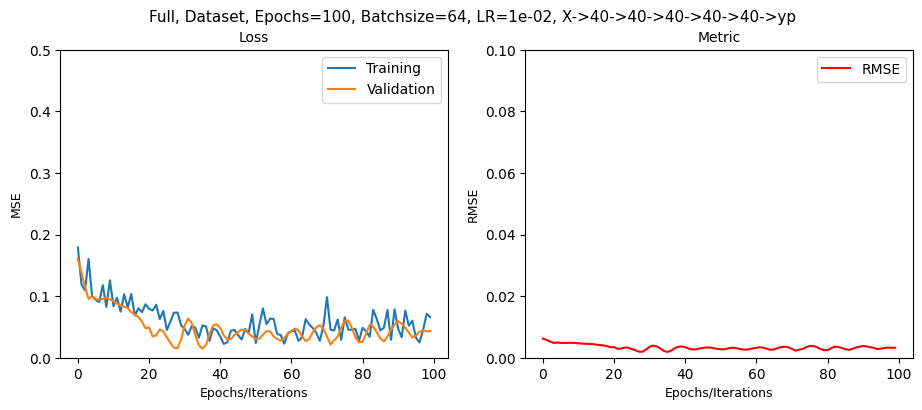

In [9]:
tl = []
vl = []
acc = []
for t in tqdm(range(epochs)):
    train_loss = mt.train(train_dataloader, model, loss_fn, optimizer)
    test_loss, metric = mt.test(train_dataloader, model, loss_fn)
    tl.append(train_loss)
    vl.append(test_loss)
    acc.append(metric)
    if t % 1 == 0:
        print(f"Epoch {t}\n-------------------------")
        print(f"Test error: \n Performance {(metric):>0.4e}, Avg loss: {test_loss:>8e} \n")
print("Done!\n")

plots = gc.plot_performance(train_loss=tl, test_loss=vl, accuracy=acc, model_name=model_name)
# plt.savefig(f"{plot_path}.png")
print(f"For training: \n Mean RMSE {(np.array(acc).mean()):>0.4e}, Mean loss: {np.array(test_loss).mean():>8e} \n")
plt.show()

Save model

In [10]:
# torch.save(model.state_dict(), os.path.join(path_to_models, model_name))

In [11]:
a = gc.compute_integral([0.8, 0.2, 0.1, 1])
b = model(torch.atleast_2d(torch.tensor([0.8, 0.2, 0.1, 1])))
outs = [a,
      b.item(),
      ((a - b)/a).item()]

outs = list(map(lambda x: f'{x:.3f}', outs))
outs[-1] = f'{float(outs[-1]):.1%}'
outs
print(*outs, '\n')

0.467 0.505 -8.3% 

